# Warsaw Air Pollution

<span style="color: gray; font-size:1em;">Mateusz Zajac</span>
<br><span style="color: gray; font-size:1em;">Jul-2020</span>


## Table of Contents
- [Part I - Log Transformation](#log)
- [Part II - Lag Features](#lag)
- [Part III - Rolling Mean Features](#roll)
- [Part IV - Mean & Median Aggregations](#mm)
- [Part V - Dummy Variables](#dummy)
- [Part VI - Factorize Categorical Variables](#factor)

In [1]:
import pandas as pd
import numpy as np

import datetime
import calendar
import itertools

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]

import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019.h5')

In [3]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,season,PM25_nie_mean,PM25_wok_mean
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,Winter,41.406660,37.978489
1,2015-01-01 01:00:00,33.90,1.0,31.11,0.89,unknown,0.0,0.0,1027.7,33.90,0.0,2.733,260.0,6.93,71.8204,68.982316,1,1,1,3,1,2015,0,Winter,58.400547,60.969357
2,2015-01-01 02:00:00,27.73,1.0,31.59,0.91,cloudy,0.0,0.0,1027.7,33.81,0.0,2.733,260.0,6.93,42.6996,48.707108,2,1,1,3,1,2015,0,Winter,50.865866,42.960510
3,2015-01-01 03:00:00,27.73,1.0,32.76,0.96,fog,0.0,0.0,1027.7,33.81,0.0,1.244,251.0,6.93,38.2824,37.986883,3,1,1,3,1,2015,0,Winter,43.679332,37.038594
4,2015-01-01 04:00:00,26.41,1.0,32.89,0.97,fog,0.0,0.0,1027.7,33.73,0.0,1.152,251.0,8.96,35.4194,33.675489,4,1,1,3,1,2015,0,Winter,36.976514,32.364739


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 26 columns):
datetime               43848 non-null datetime64[ns]
apparentTemperature    43848 non-null float64
cloudCover             43848 non-null float64
dewPoint               43848 non-null float64
humidity               43848 non-null float64
icon                   43848 non-null object
precipIntensity        43848 non-null float64
precipProbability      43848 non-null float64
pressure               43848 non-null float64
temperature            43848 non-null float64
uvIndex                43848 non-null float64
visibility             43848 non-null float64
windBearing            43848 non-null float64
windSpeed              43848 non-null float64
PM25_nie               43848 non-null float64
PM25_wok               43848 non-null float64
hour                   43848 non-null int64
day                    43848 non-null int64
dayofyear              43848 non-null int64
weekday          

<a id='log'></a>
# Part I - Log Transformation

In [5]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(8,4))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=50,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

In [6]:
# getting log1p for PM25 and 2 other skewed distributions, that seems to be important
# while looking at the correlation matrix

log_feats = ['humidity', 'windSpeed', 'PM25_nie', 'PM25_wok']

for feat in log_feats:
    df['{}_log'.format(feat)] = np.log1p(df[feat].values)

In [7]:
# assign meaningful column names
df.rename(columns={'season_Autumn':'Autumn', 'season_Spring':'Spring', 
                           'season_Summer':'Summer', 'season_Winter':'Winter'}, inplace=True)

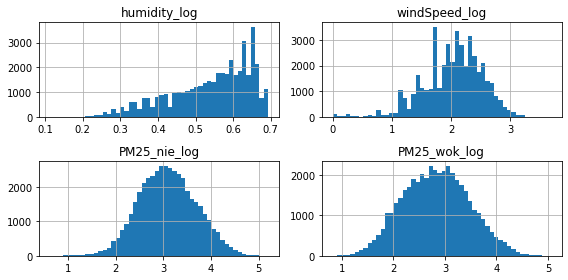

In [8]:
log_feats = ['humidity_log', 'windSpeed_log', 'PM25_nie_log', 'PM25_wok_log']

draw_histograms(df, log_feats, 2, 2)

In [9]:
# calculate Relative Humidity
# RH: =100*(EXP((17.625*TD)/(243.04+TD))/EXP((17.625*T)/(243.04+T)))
# TD= dew point // T = temperature
# df['RH'] = 100*(np.exp((17.625*df['dewPoint'])/(243.04+df['dewPoint']))/np.exp((17.625*df['temperature'])/(243.04+df['temperature'])))

In [10]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,season,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,Winter,41.406660,37.978489,0.625938,2.070653,3.960878,3.957379
1,2015-01-01 01:00:00,33.90,1.0,31.11,0.89,unknown,0.0,0.0,1027.7,33.90,0.0,2.733,260.0,6.93,71.8204,68.982316,1,1,1,3,1,2015,0,Winter,58.400547,60.969357,0.636577,2.070653,4.287996,4.248243
2,2015-01-01 02:00:00,27.73,1.0,31.59,0.91,cloudy,0.0,0.0,1027.7,33.81,0.0,2.733,260.0,6.93,42.6996,48.707108,2,1,1,3,1,2015,0,Winter,50.865866,42.960510,0.647103,2.070653,3.777339,3.906148
3,2015-01-01 03:00:00,27.73,1.0,32.76,0.96,fog,0.0,0.0,1027.7,33.81,0.0,1.244,251.0,6.93,38.2824,37.986883,3,1,1,3,1,2015,0,Winter,43.679332,37.038594,0.672944,2.070653,3.670777,3.663225
4,2015-01-01 04:00:00,26.41,1.0,32.89,0.97,fog,0.0,0.0,1027.7,33.73,0.0,1.152,251.0,8.96,35.4194,33.675489,4,1,1,3,1,2015,0,Winter,36.976514,32.364739,0.678034,2.298577,3.595102,3.546033


<a id='lag'></a>
# Part II - Lag Features

In [11]:
# create 1h and 24h lags
feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 
         'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility',
         'windBearing', 'windSpeed']
lags = [1, 24]

for lag in lags:
    for feat in feats:
        df['{0}_lag{1}h'.format(feat, lag)] = df[feat].shift(lag).astype('float32')

In [12]:
# backfill missing values
lag_cols = [col for col in df.columns if 'lag' in col]

for col in lag_cols:
    df[col] = df[col].fillna(method ='bfill')

<a id='roll'></a>
# Part III - Rolling Mean Features

In [13]:
feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 
         'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility',
         'windBearing', 'windSpeed']
rolls = [12, 24, 72, 168]

# create rolling means
for roll in rolls:
    for feat in feats:
        df['{0}_rolling{1}h'.format(feat, roll)] = df[feat].rolling(roll).mean()

In [14]:
# backfill missing values
rolling_cols = [col for col in df.columns if 'rolling' in col]

for col in rolling_cols:
    df[col] = df[col].fillna(method ='bfill')

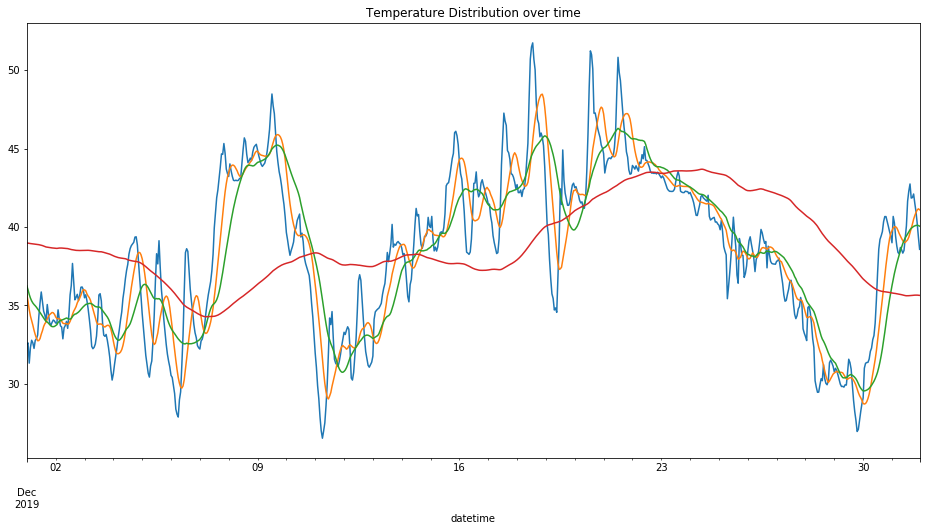

In [15]:
# check the moving averages for Dec-19 on a chart
feats = ['temperature', 'temperature_rolling12h', 'temperature_rolling24h', 'temperature_rolling168h']


for x in feats:
    df_copy = df.copy()
    df_copy.index = df.datetime
    plt.title('Temperature Distribution over time')
    df_copy[-744:][x].plot(figsize=(16,8));

<a id='mm'></a>
# Part IV - Mean & Median Aggregations

In [16]:
# create mean and median per day for the below features

feats = ['apparentTemperature', 'cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 
         'precipProbability', 'pressure', 'temperature', 'uvIndex', 'visibility',
         'windBearing', 'windSpeed', 'PM25_nie', 'PM25_wok', 'PM25_nie_log', 'PM25_wok_log']
aggreg = ['mean', 'median']


# group by day, then compute mean and median value
dfs_day = []

for aggs in aggreg:
    for feat in feats:
        globals()['{0}_{1}_per_day'.format(aggs, feat)] = df.groupby('dayofyear')[feat].agg(aggs).reset_index()
        dfs_day.append(globals()['{0}_{1}_per_day'.format(aggs, feat)])


# group by month, then compute mean and median value
dfs_month = []

for aggs in aggreg:
    for feat in feats:
        globals()['{0}_{1}_per_month'.format(aggs, feat)] = df.groupby('month')[feat].agg(aggs).reset_index()
        dfs_month.append(globals()['{0}_{1}_per_month'.format(aggs, feat)])
        

In [17]:
# assign meaningful column names
for aggs in aggreg:
    for feat in feats:
        globals()['{0}_{1}_per_day'.format(aggs, feat)].rename(columns={feat: '{0}_{1}_per_day'.format(aggs, feat)}, inplace=True)
        globals()['{0}_{1}_per_month'.format(aggs, feat)].rename(columns={feat: '{0}_{1}_per_month'.format(aggs, feat)}, inplace=True)       

In [18]:
# merge dataframes
for x in dfs_day:
    df = pd.merge(df, x, on='dayofyear', how='left')

In [19]:
# merge dataframes
for y in dfs_month:
    df = pd.merge(df, y, on='month', how='left')

#### Calculate deviations from the daily or monthly mean and median

In [20]:
df['PM25_nie_diff_for_day_median'] = df['median_PM25_nie_per_day'] - df['PM25_nie']
df['PM25_nie_diff_for_day_mean'] = df['mean_PM25_nie_per_day'] - df['PM25_nie']
df['PM25_nie_diff_for_month_median'] = df['median_PM25_nie_per_month'] - df['PM25_nie']
df['PM25_nie_diff_for_month_mean'] = df['mean_PM25_nie_per_month'] - df['PM25_nie']

df['PM25_wok_diff_for_day_median'] = df['median_PM25_wok_per_day'] - df['PM25_wok']
df['PM25_wok_diff_for_day_mean'] = df['mean_PM25_wok_per_day'] - df['PM25_wok']
df['PM25_wok_diff_for_month_median'] = df['median_PM25_wok_per_month'] - df['PM25_wok']
df['PM25_wok_diff_for_month_mean'] = df['mean_PM25_wok_per_month'] - df['PM25_wok']

In [21]:
# check correctness of the calculation
df[['median_PM25_nie_per_month', 'PM25_nie', 'PM25_nie_diff_for_month_median']].head()

,median_PM25_nie_per_month,PM25_nie,PM25_nie_diff_for_month_median
0,32.426627,51.5034,-19.076773
1,32.426627,71.8204,-39.393773
2,32.426627,42.6996,-10.272973
3,32.426627,38.2824,-5.855773
4,32.426627,35.4194,-2.992773


<a id='dummy'></a>
# Part V - Dummy Variables

In [22]:
# get dummies
df = pd.get_dummies(data=df, columns=['season'])

# assign meaningful column names
df.rename(columns={'season_Autumn':'Autumn', 'season_Spring':'Spring', 
                           'season_Summer':'Summer', 'season_Winter':'Winter'}, inplace=True)

<a id='factor'></a>
# Part VI - Factorize Categorical Variables

In [23]:
df['icon_num'] = df['icon'].factorize()[0]

In [24]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,apparentTemperature_rolling72h,cloudCover_rolling72h,dewPoint_rolling72h,humidity_rolling72h,precipIntensity_rolling72h,precipProbability_rolling72h,pressure_rolling72h,temperature_rolling72h,uvIndex_rolling72h,visibility_rolling72h,windBearing_rolling72h,windSpeed_rolling72h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h,mean_apparentTemperature_per_day,mean_cloudCover_per_day,mean_dewPoint_per_day,mean_humidity_per_day,mean_precipIntensity_per_day,mean_precipProbability_per_day,mean_pressure_per_day,mean_temperature_per_day,mean_uvIndex_per_day,mean_visibility_per_day,mean_windBearing_per_day,mean_windSpeed_per_day,mean_PM25_nie_per_day,mean_PM25_wok_per_day,mean_PM25_nie_log_per_day,mean_PM25_wok_log_per_day,median_apparentTemperature_per_day,median_cloudCover_per_day,median_dewPoint_per_day,median_humidity_per_day,median_precipIntensity_per_day,median_precipProbability_per_day,median_pressure_per_day,median_temperature_per_day,median_uvIndex_per_day,median_visibility_per_day,median_windBearing_per_day,median_windSpeed_per_day,median_PM25_nie_per_day,median_PM25_wok_per_day,median_PM25_nie_log_per_day,median_PM25_wok_log_per_day,mean_apparentTemperature_per_month,mean_cloudCover_per_month,mean_dewPoint_per_month,mean_humidity_per_month,mean_precipIntensity_per_month,mean_precipProbability_per_month,mean_pressure_per_month,mean_temperature_per_month,mean_uvIndex_per_month,mean_visibility_per_month,mean_windBearing_per_month,mean_windSpeed_per_month,mean_PM25_nie_per_month,mean_PM25_wok_per_month,mean_PM25_nie_log_per_month,mean_PM25_wok_log_per_month,median_apparentTemperature_per_month,median_cloudCover_per_month,median_dewPoint_per_month,median_humidity_per_month,median_precipIntensity_per_month,median_precipProbability_per_month,median_pressure_per_month,median_temperature_per_month,median_uvIndex_per_month,median_visibility_per_month,median_windBearing_per_month,median_windSpeed_per_month,median_PM25_nie_per_month,median_PM25_wok_per_month,median_PM25_nie_log_per_month,median_PM25_wok_log_per_month,PM25_nie_diff_for_day_median,PM25_nie_diff_for_day_mean,PM25_nie_diff_for_month_median,PM25_nie_diff_for_month_mean,PM25_wok_diff_for_day_median,PM25_wok_diff_for_day_mean,PM25_wok_diff_for_month_median,PM25_wok_diff_for_month_mean,Autumn,Spring,Summer,Winter,icon_num
0,2015-01-01 00:00:00,32.93,1.0,29.56,0.87,unknown,0.0,0.0,1027.7,32.93,0.0,2.733,260.0,6.93,51.5034,51.320000,0,1,1,3,1,2015,0,41.406660,37.9

In [25]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 178 columns):
datetime                                datetime64[ns]
apparentTemperature                     float64
cloudCover                              float64
dewPoint                                float64
humidity                                float64
icon                                    object
precipIntensity                         float64
precipProbability                       float64
pressure                                float64
temperature                             float64
uvIndex                                 float64
visibility                              float64
windBearing                             float64
windSpeed                               float64
PM25_nie                                float64
PM25_wok                                float64
hour                                    int64
day                                     int64
dayofyear               

In [26]:
# check if missing values exist in the dataset
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

In [27]:
## save dataframes to hdf
df.to_hdf('data/warsaw_air_pollution_2015-2019_feature_eng.h5', key='df', format='t')